# 1. Selección de API y Definición del Problema

## API Seleccionada
- **Nombre**: Disease.sh API
- **Endpoint**: `https://disease.sh/v3/covid-19/countries`
- **Tipo de datos**: Estadísticas COVID-19 por país


## Problema de Negocio
El objetivo principal es desarrollar un sistema predictivo para anticipar brotes de COVID-19 en diferentes regiones geográficas, permitiendo a los sistemas de salud prepararse adecuadamente.


In [127]:
# Librerías para manipulación y análisis de datos
import pandas as pd  # Manipulación de datos tabulares
import numpy as np   # Operaciones numéricas y arrays

# Librerías para modelos de machine learning
from sklearn.model_selection import train_test_split, cross_val_score  # División de datos y validación cruzada
from sklearn.preprocessing import StandardScaler  # Escalado de datos
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text  # Árbol de decisión y visualización
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métricas de evaluación
import xgboost as xgb  # XGBoost para modelos avanzados

# Librerías para visualización
import seaborn as sns  # Visualizaciones estadísticas
import matplotlib.pyplot as plt  # Gráficos base

# Análisis estadístico y peticiones API
from scipy import stats  # Herramientas estadísticas
import requests  # Peticiones HTTP para API


In [106]:
# 1. Extracción de Datos
def obtener_datos_covid():
    url = "https://disease.sh/v3/covid-19/countries"
    respuesta = requests.get(url)
    return respuesta.json()

# Obtener y transformar datos
datos = obtener_datos_covid()
df = pd.json_normalize(datos)

# Guardar en CSV
df.to_csv('datos_covid.csv', index=False)

In [107]:
# Verificar valores faltantes
print("Valores faltantes:\n", df.isnull().sum())


Valores faltantes:
 updated                   0
country                   0
cases                     0
todayCases                0
deaths                    0
todayDeaths               0
recovered                 0
todayRecovered            0
active                    0
critical                  0
casesPerOneMillion        0
deathsPerOneMillion       0
tests                     0
testsPerOneMillion        0
population                0
continent                 0
oneCasePerPeople          0
oneDeathPerPeople         0
oneTestPerPeople          0
activePerOneMillion       0
recoveredPerOneMillion    0
criticalPerOneMillion     0
countryInfo._id           2
countryInfo.iso2          2
countryInfo.iso3          2
countryInfo.lat           0
countryInfo.long          0
countryInfo.flag          0
dtype: int64


In [108]:
# Eliminar duplicados
df = df.drop_duplicates()


In [109]:
# Crear nuevas características
df['tasa_mortalidad'] = (df['deaths'] / df['cases']) * 100
df['tasa_recuperacion'] = (df['recovered'] / df['cases']) * 100
df['tasa_positividad'] = (df['cases'] / df['tests']) * 100



Interpretación Gráfico 1:
El país con más casos es USA con 111,820,082 casos


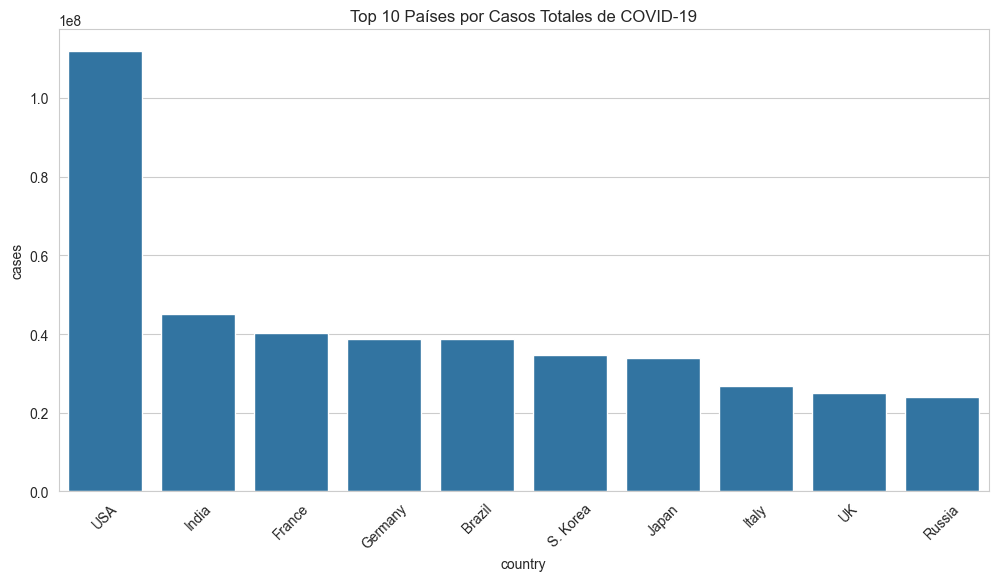

In [124]:
# 1. Top 10 países por casos totales
plt.figure(figsize=(12, 6))
top_10_casos = df.nlargest(10, 'cases')
sns.barplot(data=top_10_casos, x='country', y='cases')
plt.xticks(rotation=45)
plt.title('Top 10 Países por Casos Totales de COVID-19')
print("\nInterpretación Gráfico 1:")
print(f"El país con más casos es {top_10_casos.iloc[0]['country']} con {top_10_casos.iloc[0]['cases']:,} casos")
plt.show()


Interpretación Mapa de Calor:
Correlaciones más fuertes:
cases vs deaths: 0.89
cases vs recovered: 0.92
cases vs tests: 0.84
deaths vs recovered: 0.83
deaths vs tests: 0.80
recovered vs tests: 0.71


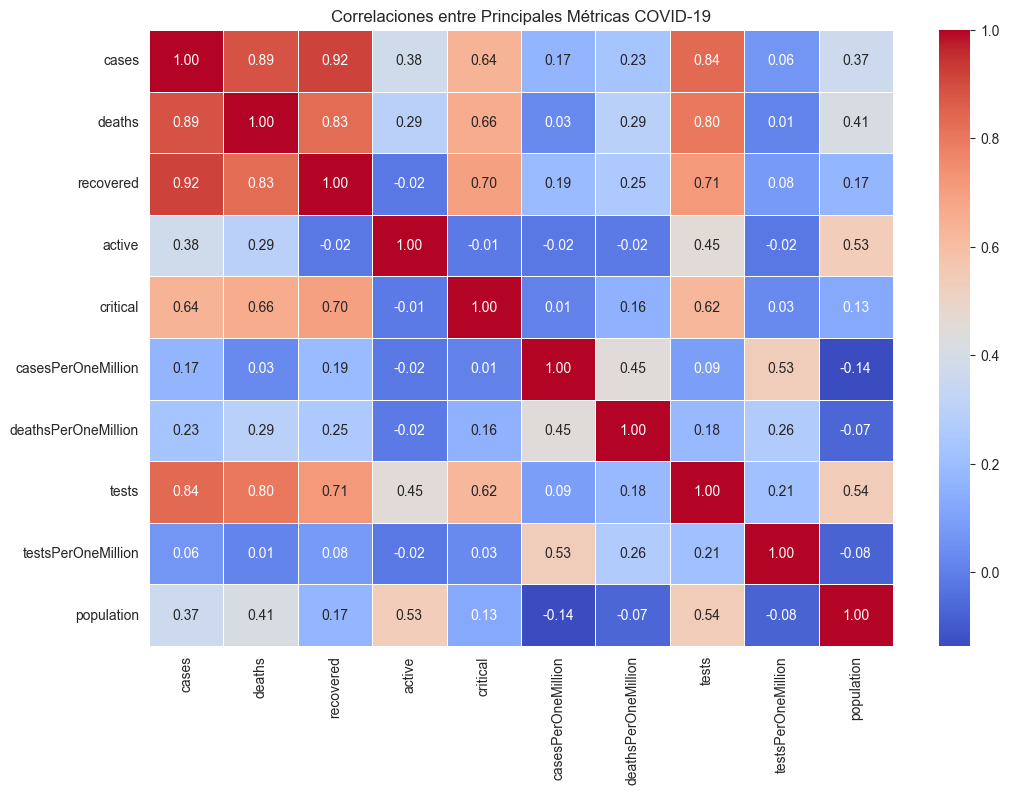

In [ ]:
# Seleccionar las 10 variables más relevantes para COVID-19
variables_relevantes = [
    'cases',
    'deaths', 
    'recovered',
    'active',
    'critical',
    'casesPerOneMillion',
    'deathsPerOneMillion',
    'tests',
    'testsPerOneMillion',
    'population'
]

# Crear matriz de correlación con las variables seleccionadas
matriz_correlacion = df[variables_relevantes].corr()

# Generar mapa de calor mejorado
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, 
            annot=True,
            cmap='coolwarm',
            linewidths=0.5,
            fmt='.2f',
            square=True)

plt.title('Mapa de Calor: Correlaciones entre Principales Métricas COVID-19')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


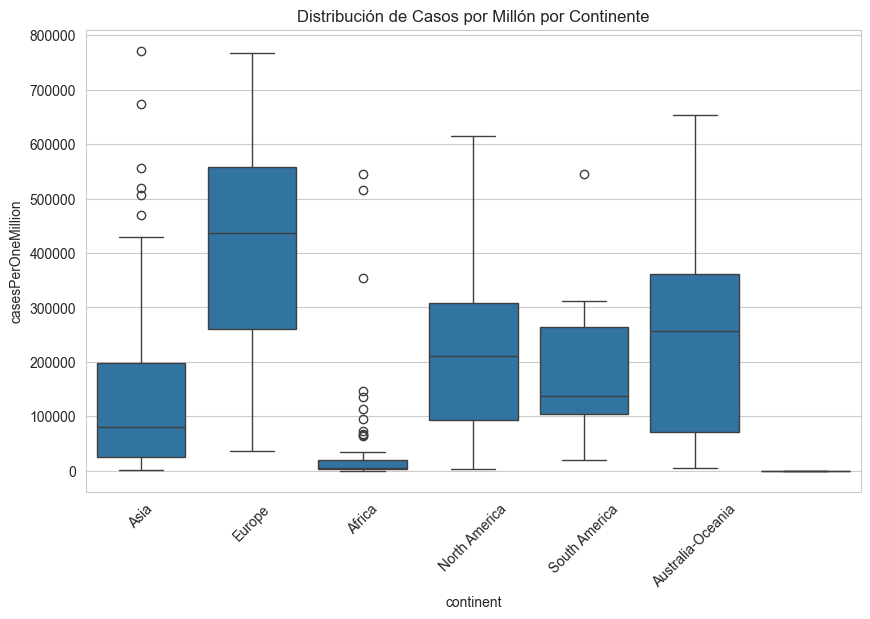

In [112]:

# Gráfico 3: Casos por Millón por Continente
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='continent', y='casesPerOneMillion')
plt.xticks(rotation=45)
plt.title('Distribución de Casos por Millón por Continente')
plt.show()

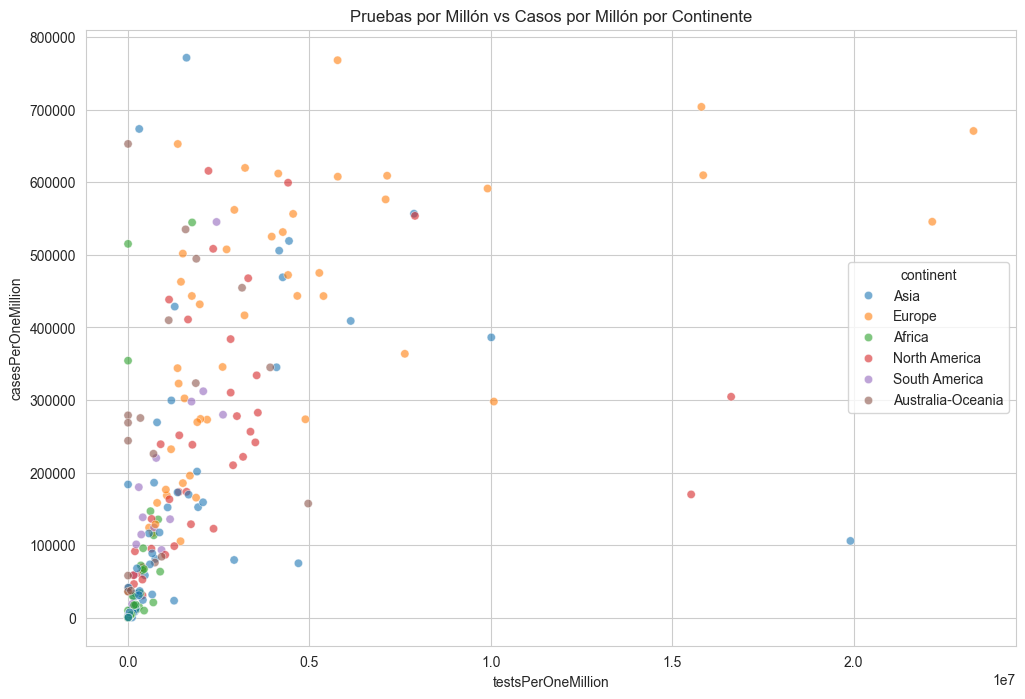

In [113]:
# Gráfico 4: Dispersión de Pruebas vs Casos por continente
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='testsPerOneMillion', y='casesPerOneMillion', 
                hue='continent', alpha=0.6)
plt.title('Pruebas por Millón vs Casos por Millón por Continente')
plt.show()

In [114]:
# Detección de valores atípicos usando Z-score
def detectar_atipicos(df, columna):
    z_scores = stats.zscore(df[columna])
    atipicos = df[abs(z_scores) > 3]
    return atipicos

In [115]:
# Detectar atípicos en casos
casos_atipicos = detectar_atipicos(df, 'cases')
print("\nValores atípicos en casos totales:")
print(casos_atipicos[['country', 'cases']])


Valores atípicos en casos totales:
      country      cases
26     Brazil   38743918
71     France   40138560
77    Germany   38828995
94      India   45035393
103     Japan   33803572
171  S. Korea   34571873
218       USA  111820082


In [116]:
# Estadísticas resumen
print("\nEstadísticas Resumen:")
display(df.describe())


Estadísticas Resumen:


C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,updated,cases,todayCases,deaths,todayDeaths,recovered,todayRecovered,active,critical,casesPerOneMillion,...,oneTestPerPeople,activePerOneMillion,recoveredPerOneMillion,criticalPerOneMillion,countryInfo._id,countryInfo.lat,countryInfo.long,tasa_mortalidad,tasa_recuperacion,tasa_positividad
count,2.310000e+02,2.310000e+02,231.0,2.310000e+02,231.0,2.310000e+02,231.000000,2.310000e+02,231.000000,231.000000,...,231.000000,231.000000,231.000000,231.000000,229.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,1.737674e+12,3.050883e+06,0.0,3.034927e+04,0.0,2.426700e+06,3.567100,5.938335e+05,12.454545,201193.108225,...,9.852814,63981.512511,135973.002424,2.250606,436.318777,17.975936,12.346804,1.385414,72.910703,inf
std,7.906747e+01,1.002125e+07,0.0,1.092314e+05,0.0,9.196220e+06,34.562905,3.893881e+06,71.172396,206119.715817,...,25.827437,149135.697501,185767.240498,9.769097,250.464566,24.281405,71.828763,2.158146,40.888779,NaN
min,1.737674e+12,9.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,-51.750000,-176.200000,0.000000,0.000000,0.314564
25%,1.737674e+12,2.636600e+04,0.0,1.855000e+02,0.0,2.189500e+03,0.000000,6.750000e+01,0.000000,17656.500000,...,0.000000,21.880000,834.905000,0.000000,222.000000,2.250000,-54.000000,0.437695,55.747960,7.715090
50%,1.737674e+12,2.068970e+05,0.0,1.974000e+03,0.0,5.894700e+04,0.000000,1.283000e+03,0.000000,128681.000000,...,1.000000,449.530000,32797.450000,0.000000,438.000000,17.000000,15.500000,0.875039,97.333268,13.249228
75%,1.737674e+12,1.348198e+06,0.0,1.428700e+04,0.0,1.032544e+06,0.000000,2.775550e+04,0.000000,328620.500000,...,5.000000,12969.700000,222352.335000,0.000000,654.000000,39.000000,46.083350,1.786124,98.948370,22.952146
max,1.737674e+12,1.118201e+08,0.0,1.219487e+06,0.0,1.098144e+08,390.000000,4.450182e+07,940.000000,771655.000000,...,196.000000,703390.000000,763121.610000,100.650000,894.000000,72.000000,178.000000,22.222222,100.000000,inf


In [117]:
# 4. Construcción de Modelos Predictivos

In [118]:
# Preparación de datos
# Seleccionamos features relevantes para predecir casos
X = df[['population', 'testsPerOneMillion', 'deathsPerOneMillion', 'recovered']]
y = df['cases']

In [119]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [120]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [121]:
# Primero, asegurémonos de tener las versiones correctas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Implementación de modelos con parámetros específicos
models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
}

# Implementación de validación cruzada manual
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Entrenamiento inicial
    model.fit(X_train_scaled, y_train)
    
    # Predicciones en conjunto de prueba
    y_pred = model.predict(X_test_scaled)
    
    # Métricas de evaluación
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    
    # Validación cruzada manual
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))
    
    results[name]['CV_Score'] = np.mean(cv_scores)

# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")



Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.2500
RMSE: 10936196.8892
R2: 0.5597
CV_Score: 0.7311


In [122]:
# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.2500
RMSE: 10936196.8892
R2: 0.5597
CV_Score: 0.7311


C:\Users\patri\AppData\Local\Temp\ipykernel_12684\294114648.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances,


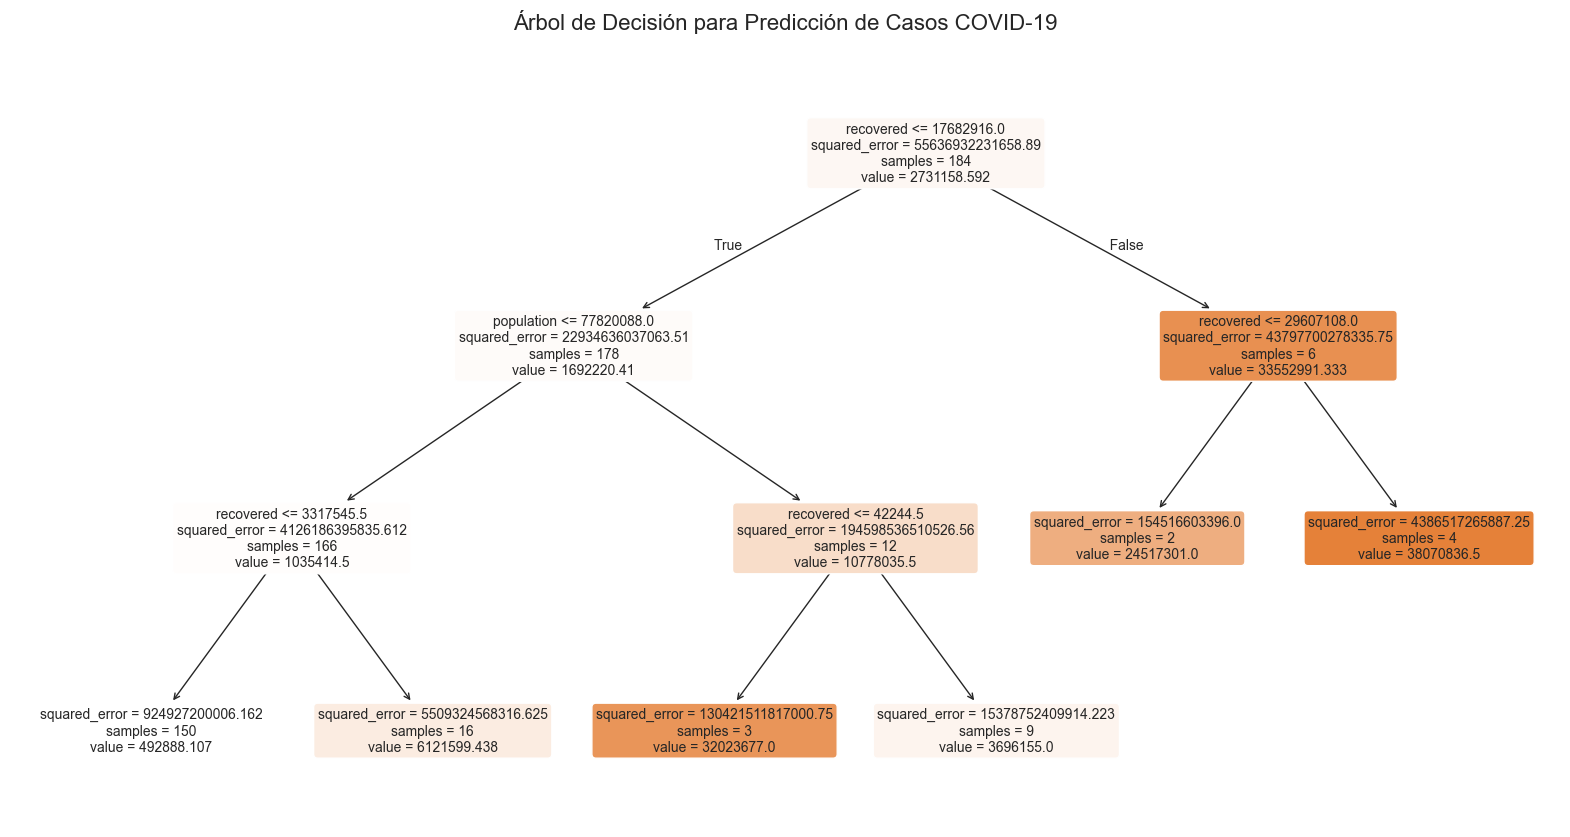

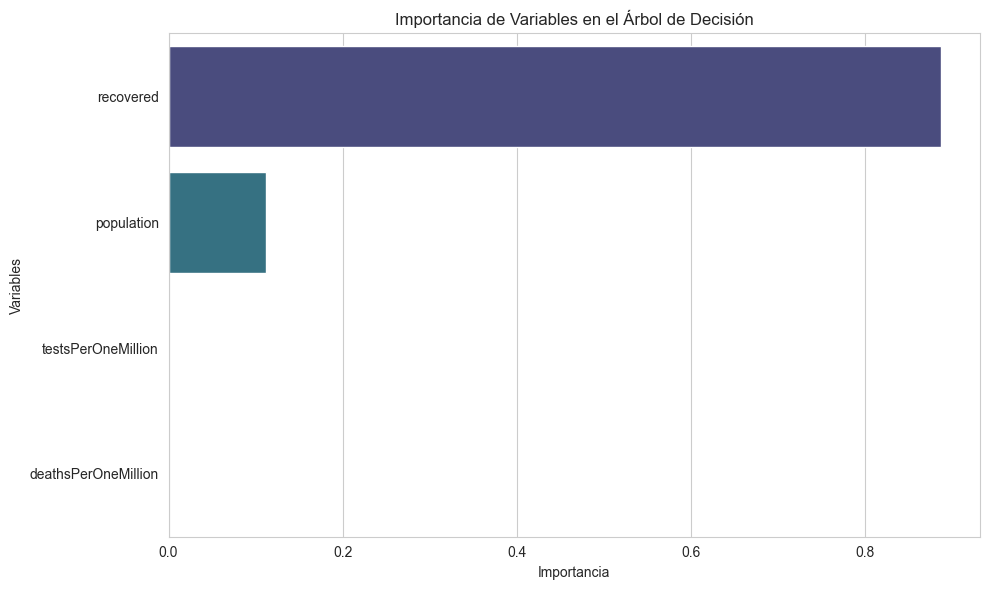

In [123]:
# 1. Preparación del modelo
# Definimos las características y variable objetivo
X = df[['population', 'testsPerOneMillion', 'deathsPerOneMillion', 'recovered']]
y = df['cases']

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el árbol de decisión
tree_model = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=5,
    random_state=42
)
tree_model.fit(X_train, y_train)

# 2. Visualización del árbol
plt.figure(figsize=(20,10))
feature_names = X.columns.tolist()

# Visualización del árbol con colores personalizados
plot_tree(tree_model,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3,
          class_names=['Casos COVID'])

plt.title('Árbol de Decisión para Predicción de Casos COVID-19', fontsize=16, pad=20)

# 3. Visualización de importancia de características
plt.figure(figsize=(10,6))
importances = pd.DataFrame({
    'features': feature_names,
    'importance': tree_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

sns.barplot(data=importances,
            x='importance',
            y='features',
            palette='viridis')
plt.title('Importancia de Variables en el Árbol de Decisión', fontsize=12)
plt.xlabel('Importancia')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()
